In [45]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.transforms as mtransforms
import matplotlib.dates as mdates

In [3]:
df_=pd.read_csv('tea_demand.csv')
df_.head(3)

,brand_id\tdate\treceipts_count
0,5152\t2016-07-01\t98
1,178\t2016-07-01\t234
2,29\t2016-07-01\t622


In [4]:
cols=df_.columns
cols=cols[0].split('\t')
cols

['brand_id', 'date', 'receipts_count']

In [5]:
df=pd.DataFrame(columns=['brand_id', 'date', 'receipts_count'])
df[['brand_id', 'date', 'receipts_count']]=df_.apply(lambda x: pd.Series(x.iloc[0].split('\t')),axis=1)
df.head(3)


,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622


In [6]:
df['timestamp']=pd.to_datetime(df['date'])
df['receipts_count']=df['receipts_count'].astype(int) 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        459 non-null    object        
 1   date            459 non-null    object        
 2   receipts_count  459 non-null    int32         
 3   timestamp       459 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 12.7+ KB


In [8]:
df.head(3)

,brand_id,date,receipts_count,timestamp
0,5152,2016-07-01,98,2016-07-01
1,178,2016-07-01,234,2016-07-01
2,29,2016-07-01,622,2016-07-01


In [31]:
lipton = df.loc[df['brand_id'].astype(int) == 29, ['timestamp', 'receipts_count']]
lipton

,timestamp,receipts_count
2,2016-07-01,622
5,2016-07-02,580
8,2016-07-03,687
11,2016-07-04,550
14,2016-07-05,529
...,...,...
446,2016-11-26,518
449,2016-11-27,493
452,2016-11-28,856
455,2016-11-29,1173


In [77]:
tea={'lipton':29,'ahmad':178,'may':5152}
def leftrightbound(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    return q1-1.5*iqr,q3+1.5*iqr
dftea=[]
aa=[]
for key,val in tea.items():
    print(key,val)
    dftea.append(df.loc[df['brand_id'].astype(int) == val, ['timestamp', 'receipts_count']])
    le,ri=leftrightbound(dftea[-1].loc[:,'receipts_count'])    
    aa.append(dftea[-1].loc[(dftea[-1]['receipts_count'] < le) | (dftea[-1]['receipts_count'] > ri), ['timestamp', 'receipts_count']]) #anomaly


lipton 29
ahmad 178
may 5152


In [80]:
#приготовить к слиянию все чаи
ren=['lipton','ahmad','may']
for ind,dft in enumerate(dftea):
    dft.rename(columns={'receipts_count':ren[ind]},inplace=True)
dftea[0].sample(3)

,timestamp,lipton
143,2016-08-17,608
68,2016-07-23,577
332,2016-10-19,920


In [81]:
comb=dftea[0].merge(dftea[1],on='timestamp').merge(dftea[2],on='timestamp')
comb.sample(3)

,timestamp,lipton,ahmad,may
125,2016-11-03,419,356,349
53,2016-08-23,500,455,100
140,2016-11-18,434,278,328


In [36]:
#установлены даты прямого эфира тв шоу "что,где,когда"
tvshowdate=['2016-09-25','2016-10-02','2016-10-09','2016-10-16','2016-10-23','2016-11-20','2016-11-27']
#добавить столбец для вывода на сводном графике баров(на полную высоту для самых больших продаж), соответствующих дням показа
tvshow = pd.DataFrame({'date': tvshowdate, 'receipts_count': [df['receipts_count'].max() for i in range(len(tvshowdate))]})
tvshow['timestamp']=pd.to_datetime(tvshow['date'])
tvshow


,date,receipts_count,timestamp
0,2016-09-25,1301,2016-09-25
1,2016-10-02,1301,2016-10-02
2,2016-10-09,1301,2016-10-09
3,2016-10-16,1301,2016-10-16
4,2016-10-23,1301,2016-10-23
5,2016-11-20,1301,2016-11-20
6,2016-11-27,1301,2016-11-27


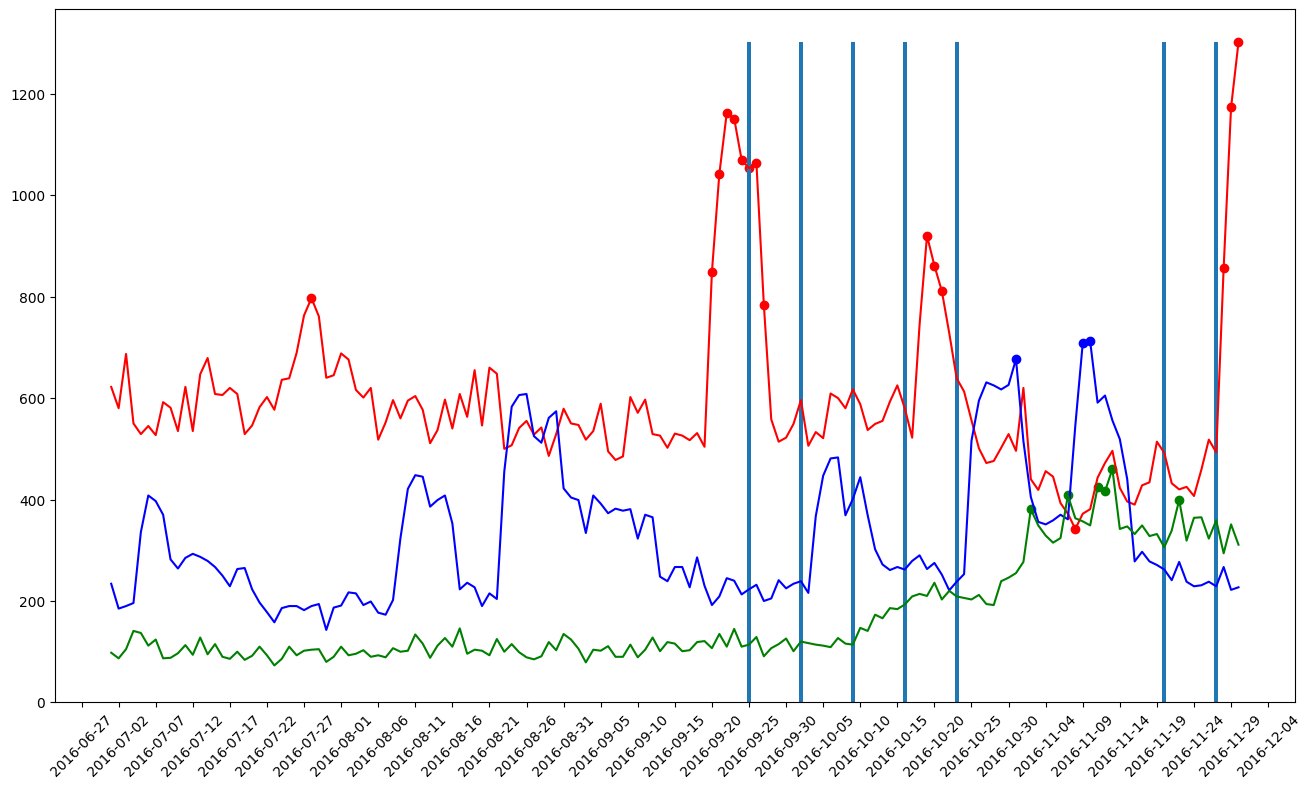

In [82]:
# вывести по трем чаям графики спроса с обозначением статистических выбросов
fig, ax = plt.subplots(figsize=(16,9))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
for ind,dft in enumerate(dftea):
    #вывести все продажи по трем чаям
    ax.plot(dft['timestamp'], dft[ren[ind]], color=colors[ind])
    #вывести точки вне 25 и 75 персентилей
    ax.scatter(aa[ind]['timestamp'],aa[ind]['receipts_count'], color=colors[ind])
#вывести бары на днях, когда показано тв шоу что,где,когда
ax.bar(tvshow['timestamp'], tvshow['receipts_count'],width=0.5)
locator = mdates.DayLocator(interval=5)
ax.xaxis.set_major_locator(locator)
plt.xticks(rotation=45)
plt.show()

In [83]:
#расширить данные новыми признаками
tv=tvshow.drop(['date','receipts_count'],axis=1)
tv['isrekl']=1
comb=comb.merge(tv,how='left',on='timestamp')
comb.head(4)

,timestamp,lipton,ahmad,may,isrekl
0,2016-07-01,622,234,98,NaN
1,2016-07-02,580,185,87,NaN
2,2016-07-03,687,190,105,NaN
3,2016-07-04,550,196,141,NaN


In [87]:
#датасет со столбцом 'isrekl' 1/0- была/не было передачи что,где когда 
comb.loc[comb['isrekl'].isnull(),['isrekl']]=0
comb.query('timestamp> "2016-09-20"') #просто посмотреть

,timestamp,lipton,ahmad,may,isrekl,isrekl_01,isrekl_02,isrekl_03,isrekl_04,isrekl_05,isrekl_06,isrekl_07,isrekl_08,isrekl_09
82,2016-09-21,1042,209,135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,2016-09-22,1162,245,110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,2016-09-23,1151,240,145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,2016-09-24,1070,213,110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,2016-09-25,1053,223,114,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2016-11-26,518,238,323,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
149,2016-11-27,493,229,359,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
150,2016-11-28,856,267,294,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
151,2016-11-29,1173,222,351,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [97]:
#добавить новые признаки (от 1 до 9 дней назад была передача)
for i in range(1,10):
    comb[f'isrekl_{i:0>2}'] = comb.isrekl.shift(i)
#добавить сумму продаж по всем чаям для оценки, если предпочтения покупателей смещаются в пределах разных чаев, но общее количество не сильно меняется
comb['sumlam'] = comb[['lipton','ahmad','may']].sum(axis=1)    
comb.query('timestamp> "2016-09-21"')

,timestamp,lipton,ahmad,may,isrekl,isrekl_01,isrekl_02,isrekl_03,isrekl_04,isrekl_05,isrekl_06,isrekl_07,isrekl_08,isrekl_09,sumlam
83,2016-09-22,1162,245,110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1517
84,2016-09-23,1151,240,145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1536
85,2016-09-24,1070,213,110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1393
86,2016-09-25,1053,223,114,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1390
87,2016-09-26,1063,232,129,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2016-11-26,518,238,323,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1079
149,2016-11-27,493,229,359,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1081
150,2016-11-28,856,267,294,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1417
151,2016-11-29,1173,222,351,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1746


In [100]:
#убрать наны для лагов
comb.loc[:10,:].fillna(0,inplace=True)
comb.head(12)


C:\Users\vsevolod.volkov\AppData\Local\Temp\ipykernel_11632\3618424847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb.loc[:10,:].fillna(0,inplace=True)


,timestamp,lipton,ahmad,may,isrekl,isrekl_01,isrekl_02,isrekl_03,isrekl_04,isrekl_05,isrekl_06,isrekl_07,isrekl_08,isrekl_09,sumlam
0,2016-07-01,622,234,98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,954
1,2016-07-02,580,185,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,852
2,2016-07-03,687,190,105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,982
3,2016-07-04,550,196,141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,887
4,2016-07-05,529,336,137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1002
5,2016-07-06,545,408,112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1065
6,2016-07-07,527,397,124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1048
7,2016-07-08,592,370,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1049
8,2016-07-09,581,282,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,951
9,2016-07-10,535,264,97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,896


In [68]:
# import pyqtgraph as pg
# from pyqtgraph.Qt import QtCore
# def showgr(keys,*args):
#     proj="IsolationForest"
#     pens=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(255,255,255)]
#     app = pg.mkQApp(proj)
#     w = pg.PlotWidget() #axisItems = {'bottom': pg.DateAxisItem()}
#     w.showGrid(x=True, y=True)

#     symbol=None
#     for key,vals in kwargs.items():
#         for ind,val in enumerate(vals):
#             w.plot(key.values, val.values,symbol=symbol ,pen=pens[ind])
#         symbol='o'
#     w.setWindowTitle(proj)
#     pg.setConfigOptions(antialias=True)
#     w.show()
#     if __name__ == '__main__':
#         pg.exec()

In [ ]:
# inp=({'x':'timestamp','y':'receipts_count'},dftea[0],aa[0])
# # ,:[dftea[0]['receipts_count']],[aa[0]['receipts_count']])
# showgr(inp)

In [67]:
proj="IsolationForest"
pens=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(255,255,255)]
app = pg.mkQApp(proj)
w = pg.PlotWidget() #axisItems = {'bottom': pg.DateAxisItem()}
w.showGrid(x=True, y=True)
w.plot(dftea[0]['timestamp'],dftea[0]['receipts_count'].values, pen=pens[0])
w.plot(aa[0]['timestamp'].values,aa[0]['receipts_count'].values, symbol='t',pen=None,symbolBrush=pens[0])
w.setWindowTitle(proj)
pg.setConfigOptions(antialias=True)
w.show()
if __name__ == '__main__':
    pg.exec()


In [80]:
comb=dftea[0].merge(dftea[1],on='timestamp',suffixes=["0","1"]).merge(dftea[2],on='timestamp')
comb.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 152
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        153 non-null    datetime64[ns]
 1   receipts_count0  153 non-null    int32         
 2   receipts_count1  153 non-null    int32         
 3   receipts_count   153 non-null    int32         
dtypes: datetime64[ns](1), int32(3)
memory usage: 4.2 KB


<AxesSubplot: >

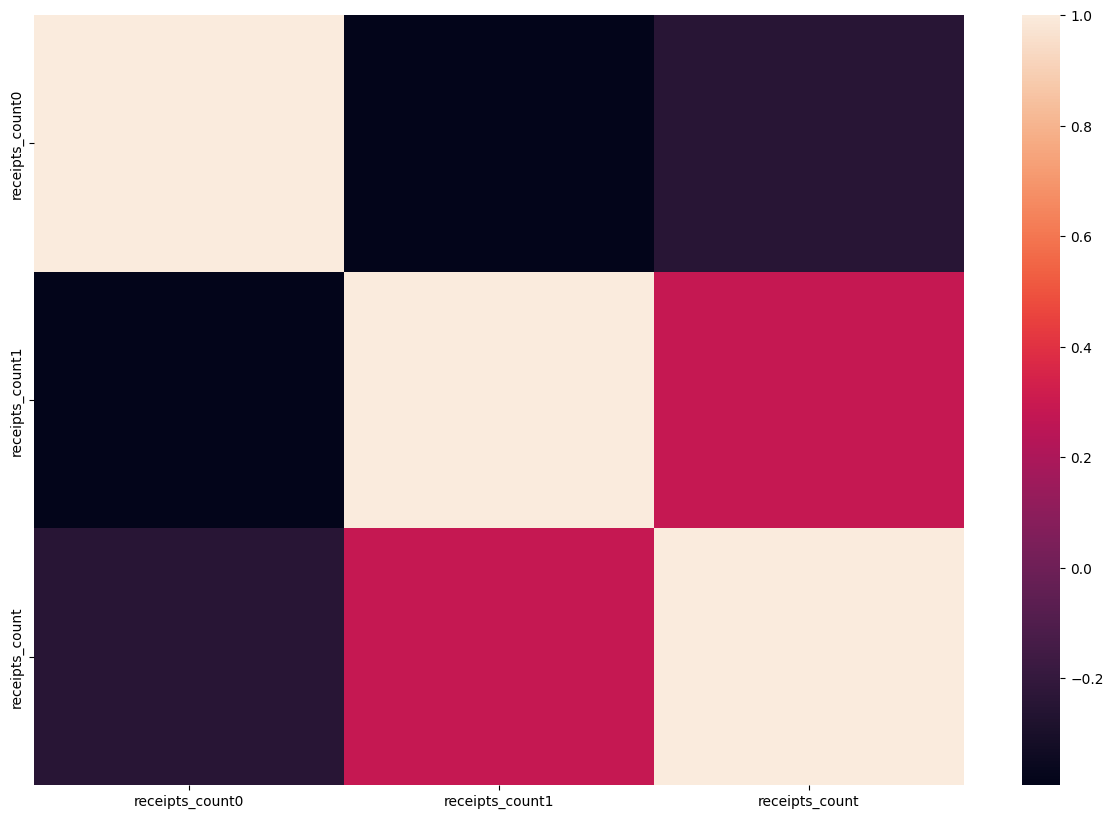

In [79]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(comb.corr(),)

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data
y = iris.target
display(X,y)

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [102]:

#In general it is a good idea to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

pca = PCA()
pca.fit(X,y)
x_new = pca.transform(X)   
x_new


array([[-2.26470281e+00,  4.80026597e-01, -1.27706022e-01,
        -2.41682039e-02],
       [-2.08096115e+00, -6.74133557e-01, -2.34608854e-01,
        -1.03006775e-01],
       [-2.36422905e+00, -3.41908024e-01,  4.42014848e-02,
        -2.83770534e-02],
       [-2.29938422e+00, -5.97394508e-01,  9.12901063e-02,
         6.59555596e-02],
       [-2.38984217e+00,  6.46835383e-01,  1.57381957e-02,
         3.59228133e-02],
       [-2.07563095e+00,  1.48917752e+00,  2.69682944e-02,
        -6.60818022e-03],
       [-2.44402884e+00,  4.76441976e-02,  3.35470401e-01,
         3.67755572e-02],
       [-2.23284716e+00,  2.23148073e-01, -8.86954979e-02,
         2.46120962e-02],
       [-2.33464048e+00, -1.11532768e+00,  1.45076864e-01,
         2.68592208e-02],
       [-2.18432817e+00, -4.69013561e-01, -2.53765567e-01,
         3.98992877e-02],
       [-2.16631010e+00,  1.04369065e+00, -2.68681102e-01,
        -1.67313672e-02],
       [-2.32613087e+00,  1.33078335e-01,  9.37592444e-02,
      

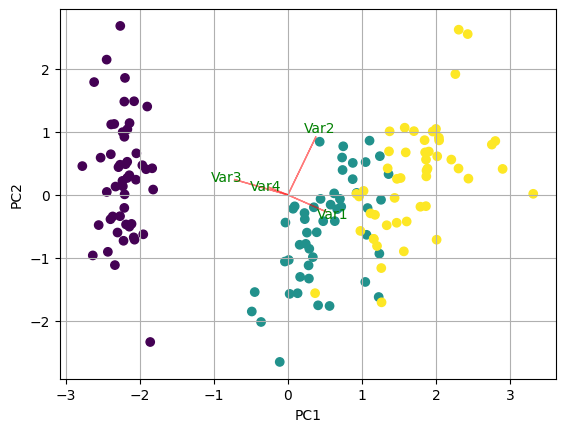

In [103]:

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c = y) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(x_new[:,0:2], pca.components_) 
plt.show()